# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [3]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.columns = ['amount']
salary.head()

,amount
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## 1. Визуальный анализ

### График ряда

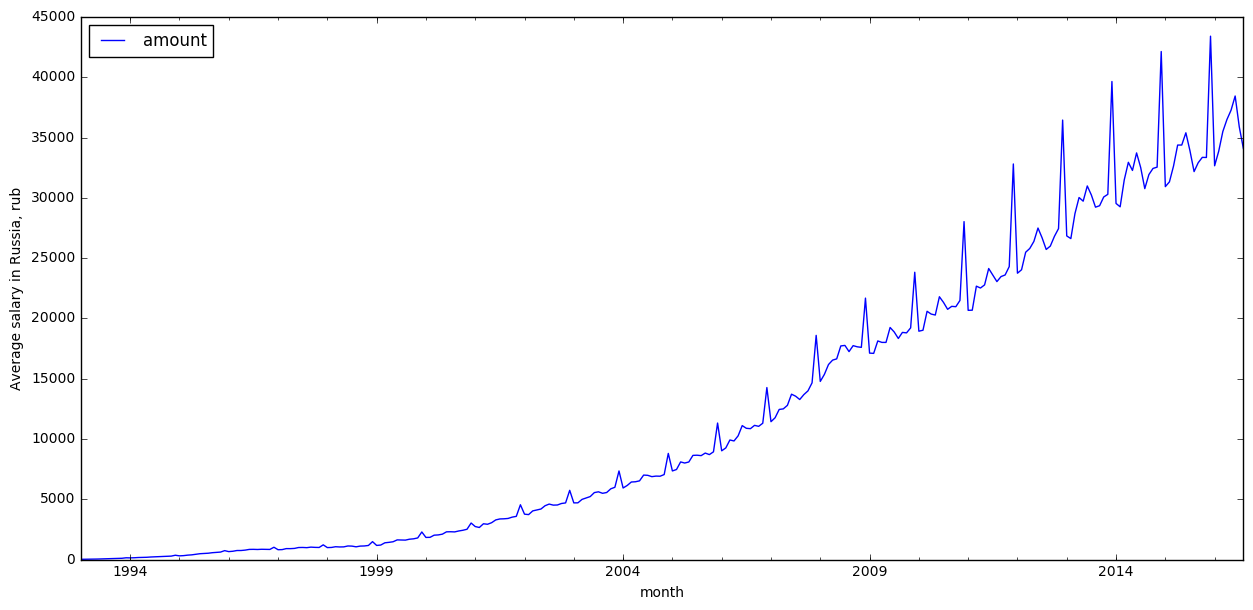

In [4]:
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('Average salary in Russia, rub')
plt.show()

### STL-декомпозиция ряда

Критерий Дики-Фуллера: p=0.991850


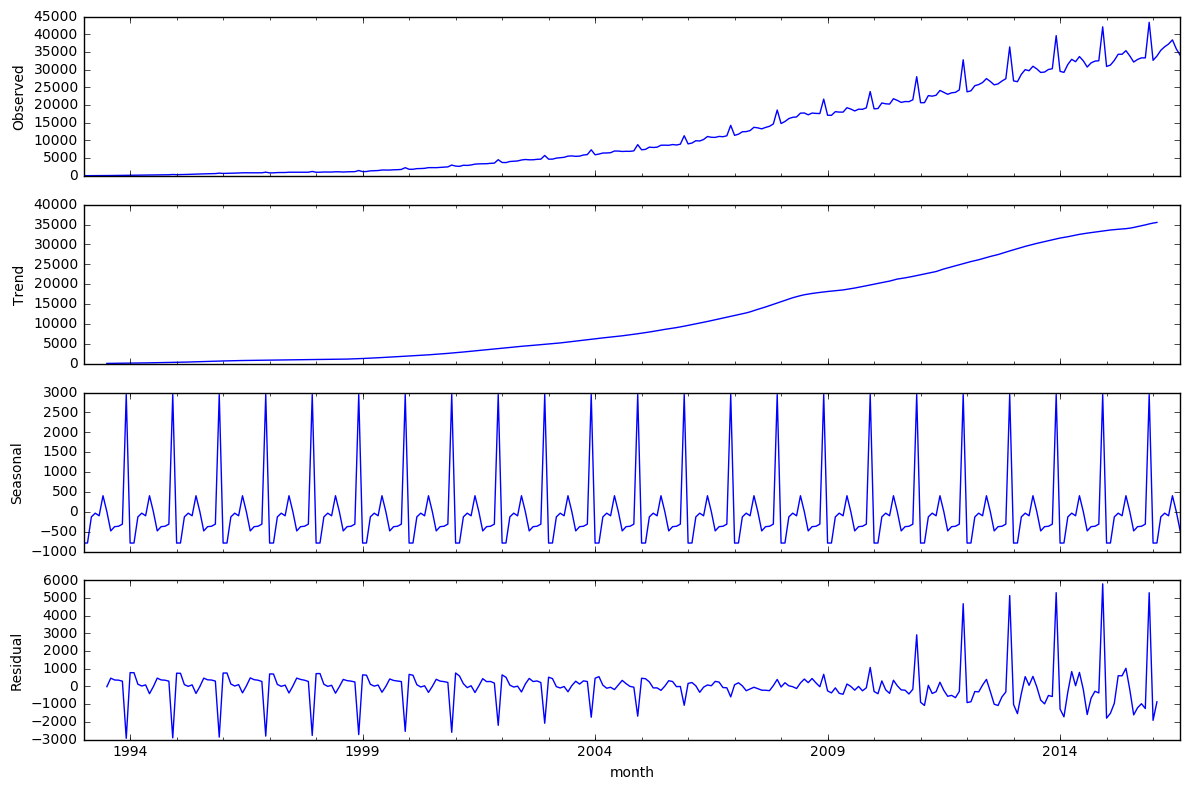

In [5]:
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(salary.amount).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.amount)[1])

Как видно из графиков, ряд имеет явный тренд и выраженную сезонность. А также по остаткам видно, что дисперсия нестабильная: до 2004 примерно одинаковая и остатки отрицательные, затем до 2010 близка к нулю и затем расходящаяся в основном с положительными остатками.

Критерий Дики-Фулера также подтверждает, что ряд явно нестационарный.

## 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


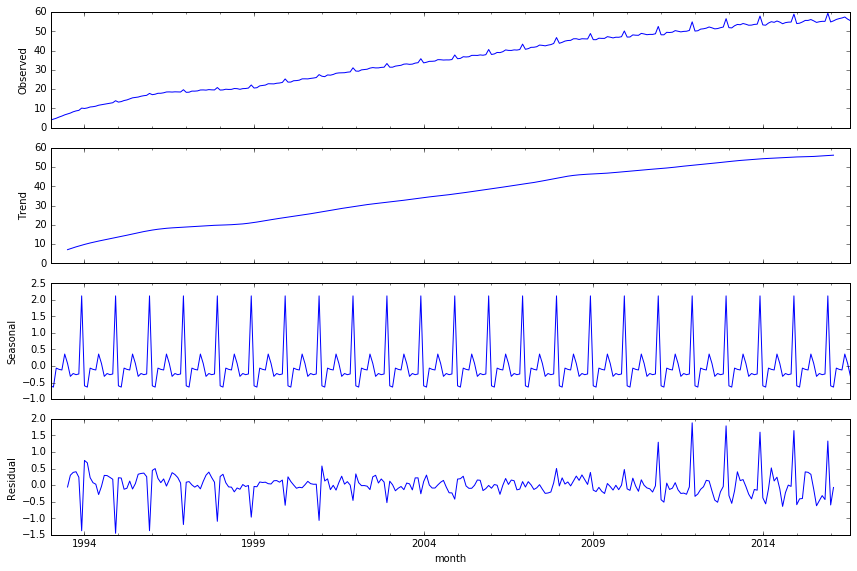

In [5]:
salary['amount_box'], lmbda = stats.boxcox(salary.amount)
plt.figure(figsize(12,8))
sm.tsa.seasonal_decompose(salary['amount_box']).plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['amount_box'])[1])

Как видно из графиков, дисперсия стала стабильней по сравнению с оригинальным рядом, но ненамного. Нестационарность никуда не делась - виден явный тренд.

## 3. Выбор порядка дифференцирования

Для того, чтобы избавиться от нестационарности, проведем дифференцирование. Добавим в таблицу значения с пребразованным рядом, продифференцированным обычно, сезонно и сезонно+обычно.

In [6]:
salary['amount_box_diff_month'] = salary.amount_box - salary.amount_box.shift(1)
salary['amount_box_diff_year'] = salary.amount_box - salary.amount_box.shift(12)
salary['amount_box_diff_both'] = salary.amount_box_diff_year - salary.amount_box_diff_year.shift(1)

Подсчитаем значения критерия Дики-Фуллера и посмотрим графики для этих рядов

Критерий Дики-Фуллера для amount_box_diff_month: p=0.0143961521649


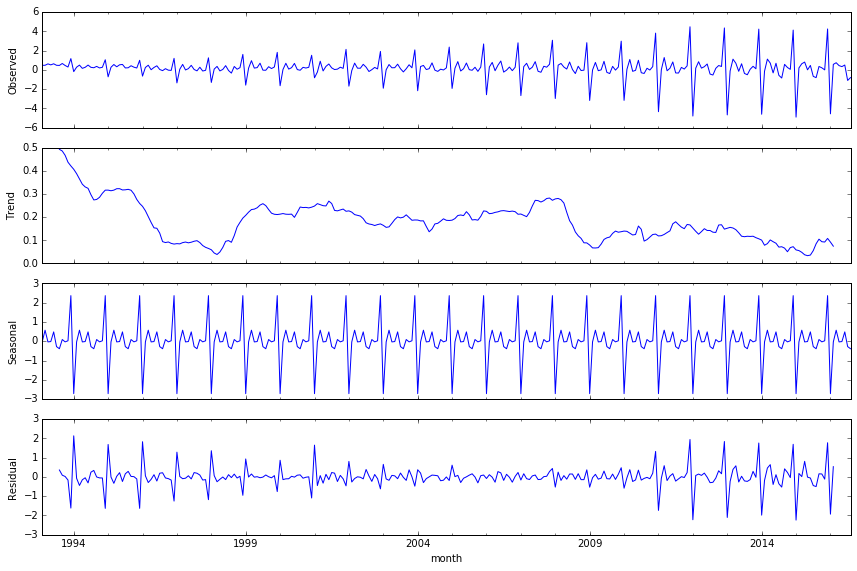

Критерий Дики-Фуллера для amount_box_diff_year: p=0.0146971334948


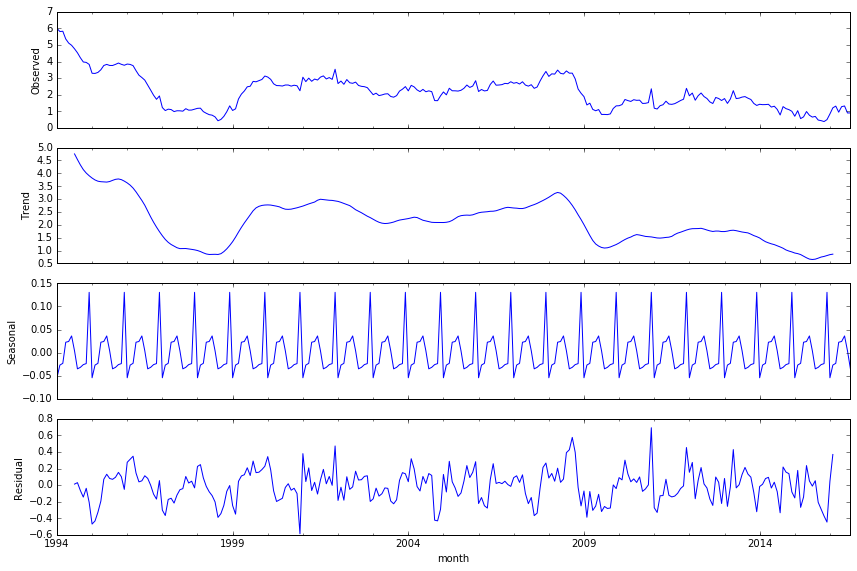

Критерий Дики-Фуллера для amount_box_diff_both: p=5.20360371582e-08


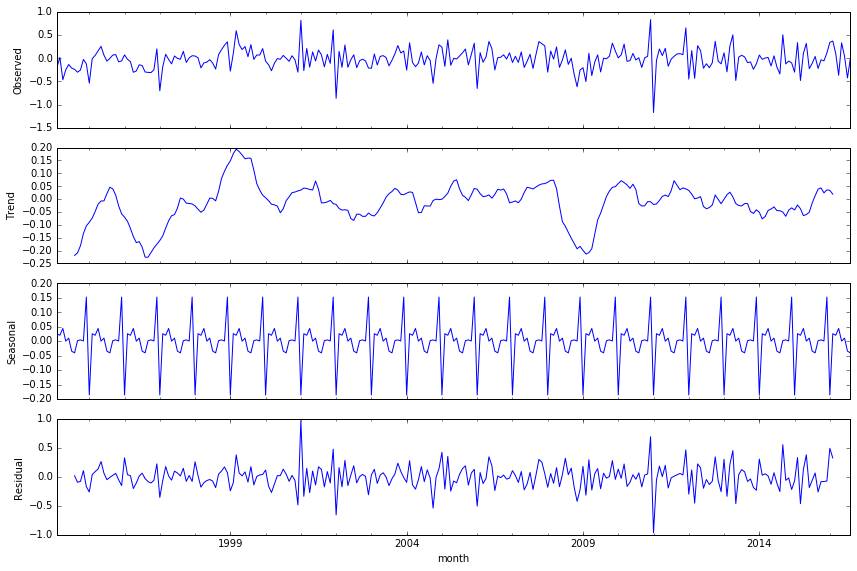

In [7]:
for diff in ['amount_box_diff_month', 'amount_box_diff_year', 'amount_box_diff_both']:
    print('Критерий Дики-Фуллера для {0}: p={1}'.format(diff, sm.tsa.stattools.adfuller(salary[diff].dropna())[1]))
    plt.figure(figsize(12,8))
    sm.tsa.seasonal_decompose(salary[diff].dropna()).plot()
    plt.show()

Как видно, критерий Дики-Фуллера отвергает гипотезу нестационарности для всех видов дифференцирования.

Но визуально ряд выглядит лучше при двойном дифференцировании, так что я остановлюсь на нем.

## 4. Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда для первых 50 лагов:

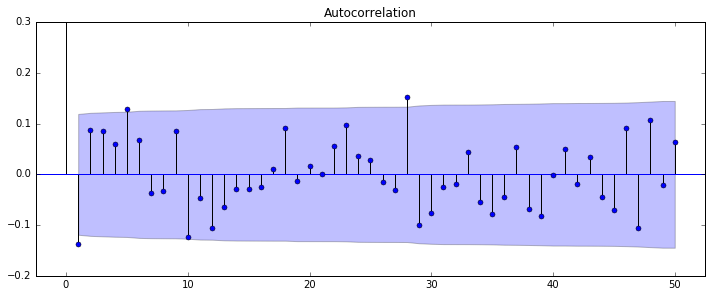

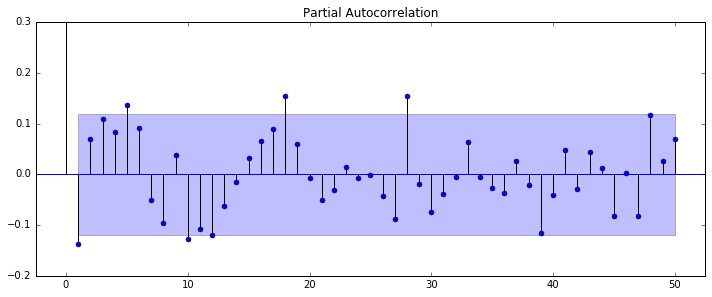

In [8]:
plt.figure(figsize(12,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary['amount_box_diff_both'].dropna().values.squeeze(), lags=50, ax=ax)
plt.ylim((-0.2, 0.3)) # чтобы лучше было видно коридор значимости
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary['amount_box_diff_both'].dropna().values.squeeze(), lags=50, ax=ax)
plt.ylim((-0.2, 0.3))
pylab.show()

Q * S - номер последнего сезонного лага, при котором автокорреляция значима

q - номер последнего несезонного лага, при котором автокорреляция значима

Получаем, что **Q = 0, q = 5**, т.к. при всех сезонных лагах автокорреляция незначима, а q = 28 не взял из-за слишком большого значения.  

P * S - номер последнего сезонного лага, при котором частичная автокорреляция значима

p - номер последнего несезонного лага, при котором частичная автокорреляция значима

Получаем, что **P = 1, p = 10**, т.к. частичная автокорреляция значима только при сезонном лаге P*S = 12, а p = 18 не взял из-за слишком большого значения.  

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [9]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = [0]

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Получается, что всего имеем {} модели'.format(len(parameters_list)))

Получается, что всего имеем 132 модели


Посчитаем для каждой из них критерий Акаике и выберем ту, у которой значение будет минимально

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.amount_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
wrong parameters: (7, 3, 0, 0)
wrong parameters: (7, 3, 1, 0)
wrong parameters: (7, 4, 0, 0)
wrong parameters: (7, 4, 1, 0)
wrong parameters: (8, 4, 0, 0)
wrong parameters: (8, 4, 1, 0)
wrong parameters: (8, 5, 0, 0)
wrong parameters: (8, 5, 1, 0)
wrong parameters: (9, 4, 0, 0)
wrong pa

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
52   (5, 5, 1, 0) -25.778808
60   (6, 5, 1, 0) -24.091079
51   (5, 5, 0, 0) -22.893847
59   (6, 5, 0, 0) -21.330743
91  (10, 3, 0, 0) -16.595426


Лучшая модель (5, 5, 1, 0), следующая за ней с меньшим числом параметров (5, 5, 0, 0) имеет критерий больше на 3 единицы, так что остановимся на первой.

Суммарная информация о лучшей модели

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         amount_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.889
Date:                            Fri, 21 Oct 2016   AIC                            -25.779
Time:                                    16:34:03   BIC                             18.009
Sample:                                01-01-1993   HQIC                            -8.223
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0034      4.903      0.001      0.999      -9.606       9.612
ar.L2          0.0088      3.281   

Из значения критерия Льюнга-Бокса Prob(Q) = 0,97 уже видно, что остатки неавтокоррелированы

## 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.180575
Критерий Дики-Фуллера: p=0.000000


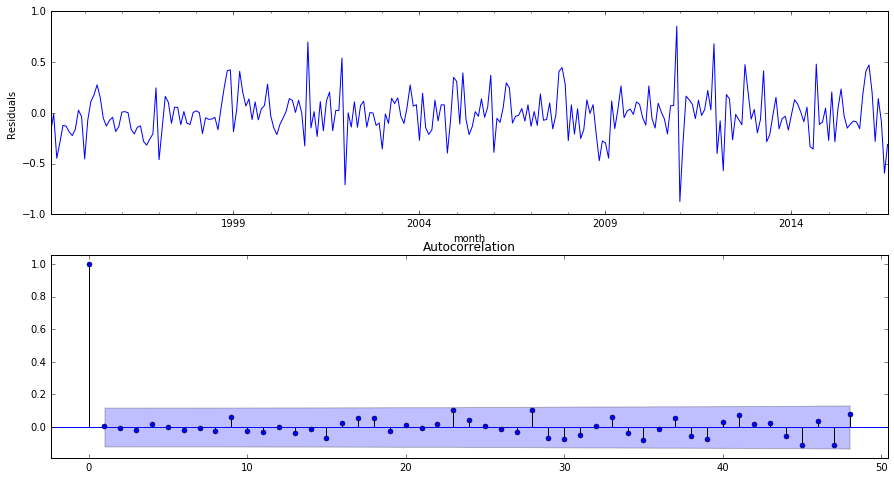

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

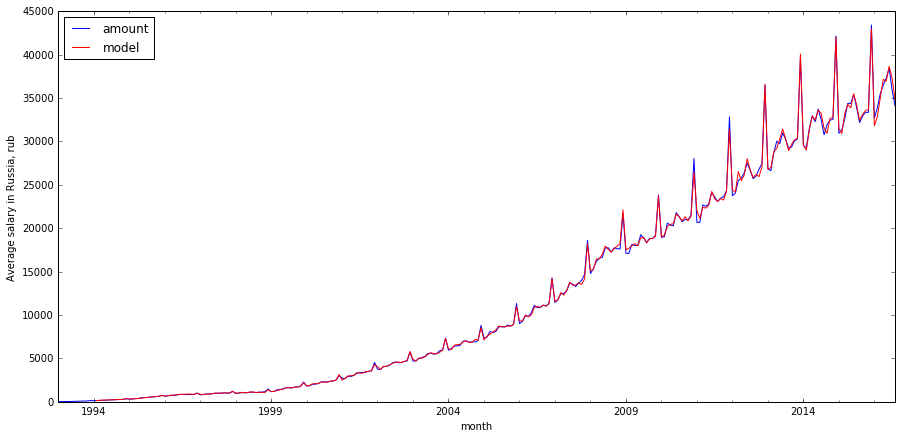

In [15]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.amount.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Average salary in Russia, rub')
plt.legend(loc=0)
plt.show()

Как видно из графика модель и данные очень похожи друг на друга, модель хорошо описывает данные.

## 7. Прогнозирование с помощью финальной модели

Построим прогноз средней зарплаты в России на 2 года с помощью выбранной модели

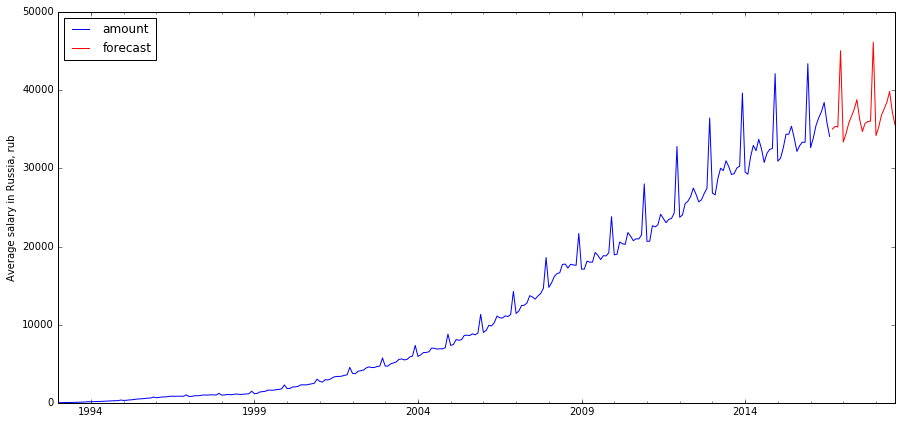

In [16]:
salary2 = salary[['amount']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=len(salary.model), end=len(salary.model)+23), lmbda)

plt.figure(figsize(15,7))
salary2.amount.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Average salary in Russia, rub')
plt.legend(loc=0)
plt.show()

Предсказанные значения можно посмотреть ниже и в будущем сравнить с фактическими:

In [17]:
salary2.tail(24)

,amount,forecast
2016-09-01,NaN,35038.268012
2016-10-01,NaN,35376.329905
2016-11-01,NaN,35310.207028
2016-12-01,NaN,45067.860365
2017-01-01,NaN,33395.736605
2017-02-01,NaN,34424.814060
2017-03-01,NaN,35782.331569
2017-04-01,NaN,36691.806439
2017-05-01,NaN,37565.364967
2017-06-01,NaN,38808.678596
